In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

In [ ]:
HBAR = 1.0
M = 0.5
TWO_M = 2 * M 


class TransferMatrixSolver:

    def __init__(self, m=M):
        self.m = m

    def get_k(self, E, V):
        
        val = 2 * self.m * (E - V) + 0j
        return np.sqrt(val) / HBAR

    def matrix_step(self, k1, k2, x):
    
        pass 

    def solve_double_barrier(self, E_array, Vb, width, separation, b_start_1, b_start_2):
        """
        Specific analytical solution for double barrier.
        """
        T_analytic = []
        R_analytic = []

        
        
        w_b = width
        w_well = separation
        
        for E in E_array:
            k_free = self.get_k(E, 0)
            k_bar  = self.get_k(E, Vb)
            
           
            def interface(k_left, k_right):
                return 0.5 * np.array([
                    [1 + k_right/k_left, 1 - k_right/k_left],
                    [1 - k_right/k_left, 1 + k_right/k_left]
                ], dtype=complex)
            
            def propagation(k, dist):
                return np.array([
                    [np.exp(-1j * k * dist), 0],
                    [0, np.exp(1j * k * dist)]
                ], dtype=complex)

          
            M = interface(k_free, k_bar)
            M = np.dot(M, propagation(k_bar, w_b))
            M = np.dot(M, interface(k_bar, k_free))
            M = np.dot(M, propagation(k_free, w_well))
            M = np.dot(M, interface(k_free, k_bar))
            M = np.dot(M, propagation(k_bar, w_b))
            M = np.dot(M, interface(k_bar, k_free))
            
            T_val = abs(1.0 / M[0,0])**2
            R_val = 1.0 - T_val
            
            T_analytic.append(T_val)
            R_analytic.append(R_val)
            
        return np.array(T_analytic), np.array(R_analytic)

class EDSimulator:
    def __init__(self, Vb, w, b, N_grid, L):
        self.Vb = Vb
        self.w = w
        self.b = b
        self.N = N_grid
        self.L = L
        self.dx = L / (self.N - 1)
        self.x = np.linspace(-L/2, L/2 , self.N)
        # fftfreq gives standard order: [0, 1, ... N/2-1, -N/2, ... -1]
        self.p = fftfreq(self.N, d=self.dx) * (2 * np.pi * HBAR)
        self.T_p_op = (self.p**2) / TWO_M 
        self.V_x_op = self.create_potential()

    def create_potential(self):
        V = np.zeros(self.N, dtype=float)

        b1_start = -self.w/2 - self.b
        b1_end = -self.w/2
        barrier1_cond = (self.x >= b1_start) & (self.x < b1_end)
        V[barrier1_cond] = self.Vb
        

        b2_start = self.w/2
        b2_end = self.w/2 + self.b
        barrier2_cond = (self.x >= b2_start) & (self.x < b2_end)
        V[barrier2_cond] = self.Vb
        return V

    def create_initial_state(self, k0, x0, sigma):
        p0 = HBAR * k0
        exponent = -(self.x - x0)**2 / (2 * sigma**2)
        wave_vector = 1j * p0 * (self.x - x0) / HBAR
        psi = np.exp(exponent) * np.exp(wave_vector)

        norm = np.linalg.norm(psi)
        return psi / norm

    def run_simulation(self, k0, x0, sigma, T_total, dt):
        psi = self.create_initial_state(k0, x0, sigma)
        psi_initial = np.copy(psi)
        
        print(f"Running ED Simulation... (Grid size: {self.N})")
        n_steps = int(T_total / dt)
        
 
        exp_V = np.exp(-1j * self.V_x_op * dt / (2 * HBAR))
        exp_T = np.exp(-1j * self.T_p_op * dt / HBAR)
        
        # Time evolution loop
        for _ in range(n_steps):
            psi = exp_V * psi      
            psi_p = fft(psi)       
            psi_p = exp_T * psi_p  
            psi = ifft(psi_p)      
            psi = exp_V * psi      

        return psi_initial, psi


def extract_s_matrix(psi_initial, psi_final, T_total, k0, x, p, T_p_op, N, 
                     sigma_x, w, b):
    
    psi_in_p = fft(psi_initial)
    
    barrier_left_edge = -w/2 - b
    barrier_right_edge = w/2 + b

    refl_mask = x < barrier_left_edge
    trans_mask = x > barrier_right_edge
    
    psi_refl = np.copy(psi_final)
    psi_refl[~refl_mask] = 0
    
    psi_trans = np.copy(psi_final)
    psi_trans[~trans_mask] = 0
    
    psi_refl_p = fft(psi_refl)
    psi_trans_p = fft(psi_trans)
    
    phase_correction = np.exp(1j * T_p_op * T_total / HBAR)
    
    psi_refl_p_corr = psi_refl_p * phase_correction
    psi_trans_p_corr = psi_trans_p * phase_correction
    
    epsilon = 1e-15
    
    p_shifted = np.fft.fftshift(p)
    psi_in_p_shifted = np.fft.fftshift(psi_in_p)
    psi_refl_p_shifted = np.fft.fftshift(psi_refl_p_corr)
    psi_trans_p_shifted = np.fft.fftshift(psi_trans_p_corr)
    
    positive_mask = p_shifted > 0
    p_positive = p_shifted[positive_mask]

    E_sim = (p_positive**2) / TWO_M
    
    amp_in = psi_in_p_shifted[positive_mask]

    amp_trans = psi_trans_p_shifted[positive_mask]
    
    psi_refl_p_flipped = np.flip(psi_refl_p_shifted)
    amp_refl = psi_refl_p_flipped[positive_mask] 
  
    T_sim = np.abs(amp_trans / (amp_in + epsilon))**2
    R_sim = np.abs(amp_refl  / (amp_in + epsilon))**2
    
    p0 = k0 * HBAR
    sigma_p = HBAR / (2 * sigma_x)
 
    valid_indices = (p_positive > p0 - 4*sigma_p) & (p_positive < p0 + 4*sigma_p)
    
    return E_sim[valid_indices], T_sim[valid_indices], R_sim[valid_indices]


def plot_benchmark(E_ed, T_ed, R_ed, E_ana, T_ana, R_ana, V0):
    """Plots ED results vs Analytical Theory."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    mask = E_ed > 0 
    E_ed, T_ed, R_ed = E_ed[mask], T_ed[mask], R_ed[mask]
    
    ax1.plot(E_ana, T_ana, 'k-', label='Analytical', linewidth=1.5, alpha=0.6)
    ax1.plot(E_ed, T_ed, 'bo', label='Qiskit Simulation', markersize=4, mfc='none', alpha=0.8)
    
    ax1.set_title('Transmission Probability T(E)', fontsize=14)
    ax1.set_ylabel('T(E)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_ylim(-0.05, 1.05)

    ax2.plot(E_ana, R_ana, 'k-', label='Analytical', linewidth=1.5, alpha=0.6)
    ax2.plot(E_ed, R_ed, 'ro', label='Qiskit Simulation', markersize=4, mfc='none', alpha=0.8)
    
    ax2.set_title('Reflection Probability R(E)', fontsize=14)
    ax2.set_xlabel('Energy (E)', fontsize=12)
    ax2.set_ylabel('R(E)', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_ylim(-0.05, 1.05)
    
    if len(E_ed) > 0:
        ax2.set_xlim(np.min(E_ed), np.max(E_ed))
    
    plt.tight_layout()
    plt.savefig("ED_vs_Analytical.png")
    print("\nPlot saved to 'ED_vs_Analytical.png'")
    plt.show()

Running ED Simulation... (Grid size: 4096)
Extracting S-Matrix from ED...
Calculating Analytical Solution...

Plot saved to 'ED_vs_Analytical.png'


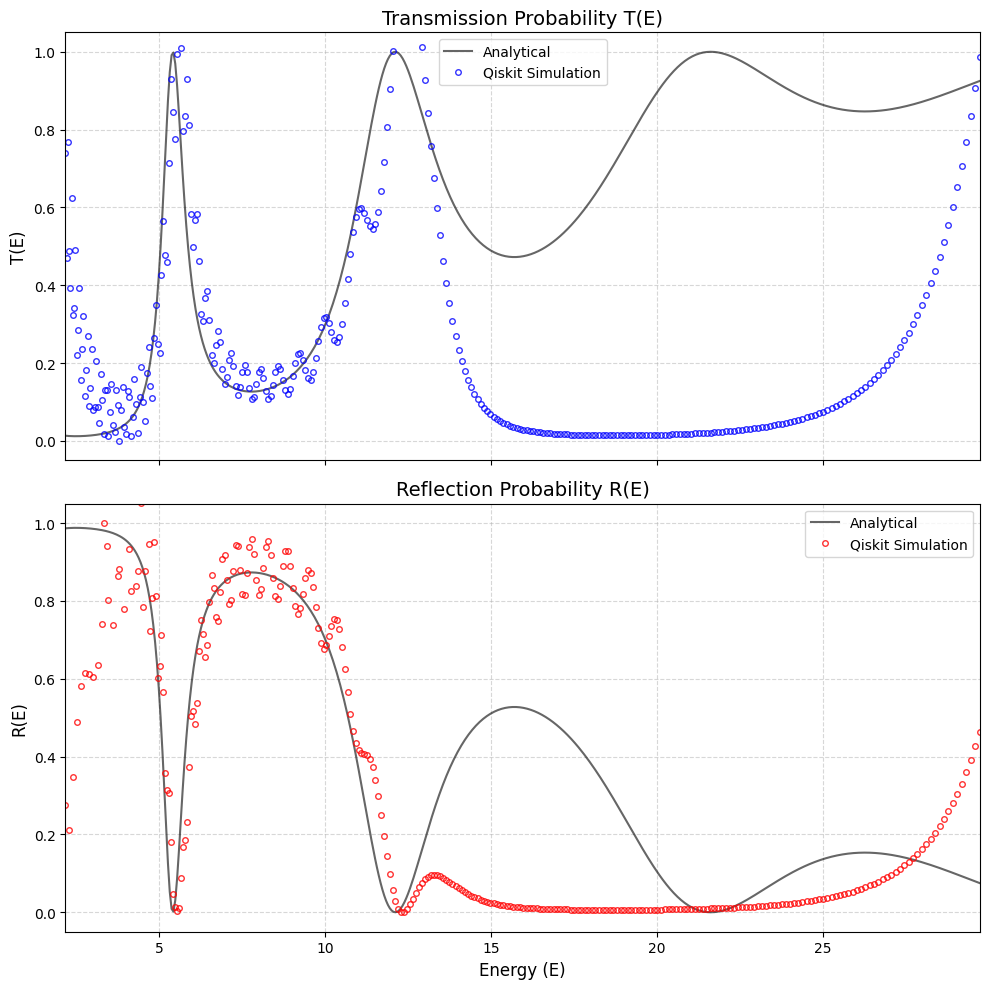

E_max under Nyquist: 662.0145717679098


In [ ]:
if __name__ == "__main__":
    
   
    N_QUBITS = 12           
    N_GRID = 2**N_QUBITS
    X_MAX = 250.0
    L = 2 * X_MAX

    k_min, k_max = 0,np.pi*(2**N_QUBITS-1)/L
    
    
    Vb = 10               
    w = 2                 
    b = 0.5                
    
    
    E_center = 12.0         
    k0_target = np.sqrt(TWO_M * E_center) / HBAR
    x0 = -50.0          
    sigma = 1.0             
    

    dt = 0.005      
    T_total = 40   
    n_steps = int(T_total / dt)
    

    sim = EDSimulator(Vb, w, b, N_GRID, L)
    psi_init, psi_final = sim.run_simulation(k0_target, x0, sigma, T_total, dt)
    
    print("Extracting S-Matrix from ED...")
    E_ed, T_ed, R_ed = extract_s_matrix(
        psi_init, psi_final, T_total, k0_target,
        sim.x, sim.p, sim.T_p_op, sim.N, sigma, w, b
    )
    
    print("Calculating Analytical Solution...")

    E_min, E_max = np.min(E_ed), np.max(E_ed)
    E_analytical_range = np.linspace(max(0.1, E_min), E_max, 500)
    
    solver = TransferMatrixSolver()
    T_ana, R_ana = solver.solve_double_barrier(
        E_analytical_range, Vb, b, w, -w/2-b, -w/2
    )
    
    plot_benchmark(E_ed, T_ed, R_ed, E_analytical_range, T_ana, R_ana, Vb)

    print("E_max under Nyquist:", k_max**2 / (TWO_M))

Simulating 12000 steps...
Analyzing S-Matrix and Time Delay...
------------------------------
Resonance Energy: 5.3360
Full Width (Gamma): 0.4455
Lifetime (hbar/Gamma): 2.2445
------------------------------


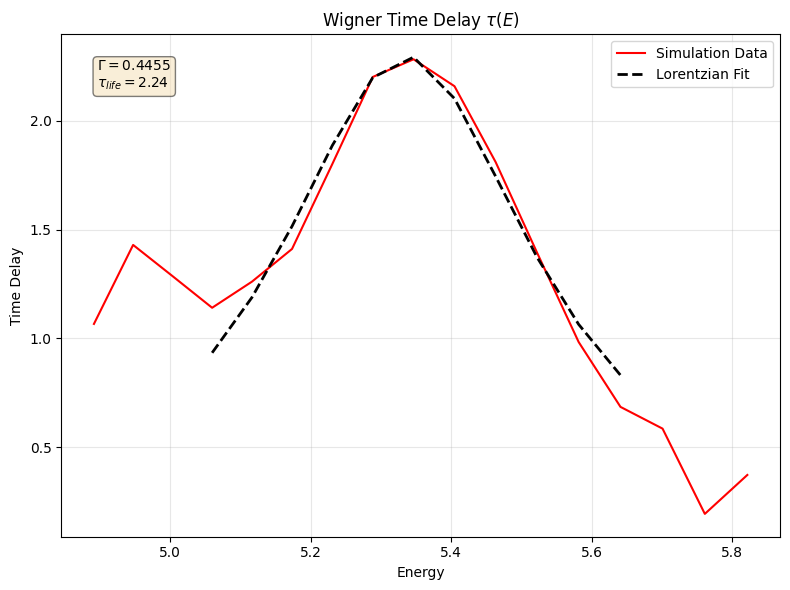

In [ ]:

from scipy.optimize import curve_fit

HBAR = 1.0
M = 0.5
TWO_M = 2 * M


N_QUBITS = 13           
N_GRID = 2**N_QUBITS
X_MAX = 250.0           
L = 2 * X_MAX


Vb = 10.0
w = 2.0                 
b = 0.5               

E_center = 5.0
k0_target = np.sqrt(TWO_M * E_center) / HBAR
x0 = -80.0              
sigma = 0.5             

dt = 0.005
T_total = 60.0          

class EDSimulator:
    def __init__(self, Vb, w, b, N_grid, L):
        self.Vb = Vb
        self.w = w
        self.b = b
        self.N = N_grid
        self.L = L
        self.dx = L / N_grid
        self.x = np.linspace(-L/2, L/2, N_grid, endpoint=False)
        self.p = fftfreq(N_grid, d=self.dx) * (2 * np.pi * HBAR)
        self.T_op = (self.p**2) / TWO_M
        self.V_x = self._create_potential()

    def _create_potential(self):
        V = np.zeros_like(self.x)
     
        b1 = (self.x >= -self.w/2 - self.b) & (self.x <= -self.w/2)
  
        b2 = (self.x >= self.w/2) & (self.x <= self.w/2 + self.b)
        V[b1 | b2] = self.Vb
        return V

    def run(self, k0, x0, sigma, T_total, dt):
        
        psi = np.exp(-(self.x - x0)**2 / (4 * sigma**2)) * np.exp(1j * k0 * self.x)
        psi /= np.linalg.norm(psi)
        psi_initial = psi.copy()


        exp_V = np.exp(-1j * self.V_x * (dt/2) / HBAR)
        exp_T = np.exp(-1j * self.T_op * dt / HBAR)

        n_steps = int(T_total / dt)
        print(f"Simulating {n_steps} steps...")


        for _ in range(n_steps):
            psi = exp_V * psi
            psi = ifft(exp_T * fft(psi))
            psi = exp_V * psi

        return psi_initial, psi

def analyze_scattering(psi_init, psi_final, T_total, x, p, T_op, w, b):
    
    phi_in = fft(psi_init)
    phase_back = np.exp(1j * T_op * T_total / HBAR)

    mask_trans = x > (w/2 + b + 2.0)
    psi_trans = psi_final * mask_trans
    phi_trans = fft(psi_trans) * phase_back


    p_s = np.fft.fftshift(p)
    phi_in_s = np.fft.fftshift(phi_in)
    phi_trans_s = np.fft.fftshift(phi_trans)


    mask_pos = p_s > 0
    p_pos = p_s[mask_pos]
    E_grid = (p_pos**2) / TWO_M

    amp_in = phi_in_s[mask_pos]
    amp_trans = phi_trans_s[mask_pos]

   
    valid = np.abs(amp_in) > 1e-10
    E_valid = E_grid[valid]
    
 
    t_E = amp_trans[valid] / amp_in[valid]
    T_prob = np.abs(t_E)**2

    
    phi_E = np.angle(t_E)
    phi_unwrap = np.unwrap(phi_E)

    dE = np.gradient(E_valid)
    dphi = np.gradient(phi_unwrap)
    tau = HBAR * dphi / dE

    return E_valid, T_prob, phi_unwrap, tau

def fit_lorentzian(E, tau, E_guess):
    
    window = 0.3
    mask = (E > E_guess - window) & (E < E_guess + window)
    E_fit = E[mask]
    tau_fit = tau[mask]

    def lorentzian_func(x, x0, gamma, A, bg):
    
        return bg + (A * (gamma/2)**2) / ((x - x0)**2 + (gamma/2)**2)

    try:
       
        p0 = [E_guess, 0.1, np.max(tau_fit), 0]
        popt, _ = curve_fit(lorentzian_func, E_fit, tau_fit, p0=p0, maxfev=5000)
        return popt, E_fit, lorentzian_func(E_fit, *popt)
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None, None

if __name__ == "__main__":

    sim = EDSimulator(Vb, w, b, N_GRID, L)
    psi_i, psi_f = sim.run(k0_target, x0, sigma, T_total, dt)

    print("Analyzing S-Matrix and Time Delay...")
    E_vals, T_prob, phi_vals, tau_vals = analyze_scattering(
        psi_i, psi_f, T_total, sim.x, sim.p, sim.T_op, w, b
    )

    mask_search = (E_vals > 4.5) & (E_vals < 5.5)
    if np.any(mask_search):
        idx_local = np.argmax(tau_vals[mask_search])
        E_r_measured = E_vals[mask_search][idx_local]
    else:
        E_r_measured = 5.0

    fit_params, E_fit, tau_fit = fit_lorentzian(E_vals, tau_vals, E_r_measured)

    print("-" * 30)
    if fit_params is not None:
        E_res, Gamma, Amp, Bg = fit_params
        Lifetime = HBAR / np.abs(Gamma)
        print(f"Resonance Energy: {E_res:.4f}")
        print(f"Full Width (Gamma): {np.abs(Gamma):.4f}")
        print(f"Lifetime (hbar/Gamma): {Lifetime:.4f}")
    else:
        print("Could not fit Lorentzian.")
    print("-" * 30)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    
    plot_range = 0.5
    mask_plot = (E_vals > E_r_measured - plot_range) & (E_vals < E_r_measured + plot_range)
    

  
    ax.plot(E_vals[mask_plot], tau_vals[mask_plot], 'r-', lw=1.5, label='Simulation Data')
    if fit_params is not None:
        ax.plot(E_fit, tau_fit, 'k--', lw=2, label='Lorentzian Fit')
  
        text_str = f"$\Gamma = {np.abs(Gamma):.4f}$\n$\\tau_{{life}} = {Lifetime:.2f}$"
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title("Wigner Time Delay $\\tau(E)$")
    ax.set_xlabel("Energy")
    ax.set_ylabel("Time Delay")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

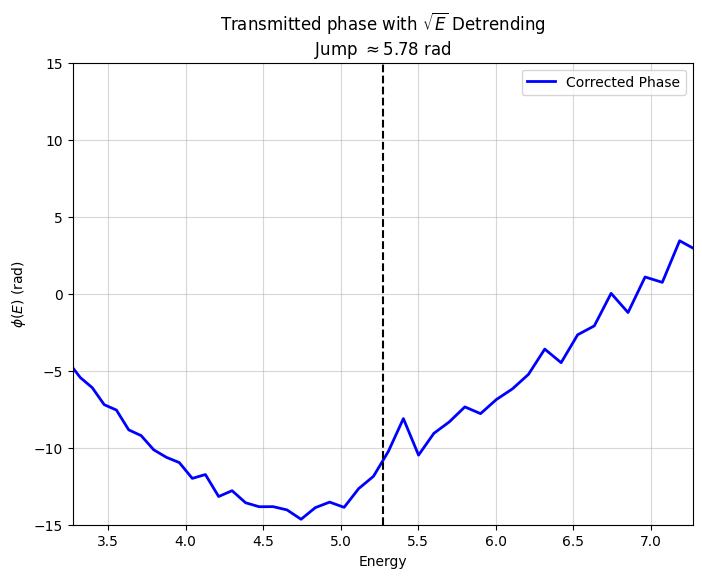

In [ ]:

from scipy.optimize import curve_fit

HBAR = 1.0
M = 0.5
TWO_M = 2 * M


N_QUBITS = 13
N_GRID = 2**N_QUBITS
X_MAX = 150.0
L = 2 * X_MAX

# Parameters
Vb = 10.0; w = 2.0; b = 0.5
E_center = 5.0; k0_target = np.sqrt(TWO_M * E_center) / HBAR
x0 = -80.0; sigma = 0.5
dt = 0.005; T_total = 60.0


class EDSimulator:
    def __init__(self, Vb, w, b, N_grid, L):
        self.Vb = Vb; self.w = w; self.b = b
        self.N = N_grid; self.L = L
        self.dx = L / N_grid
        self.x = np.linspace(-L/2, L/2, N_grid, endpoint=False)
        self.p = fftfreq(N_grid, d=self.dx) * (2 * np.pi * HBAR)
        self.T_op = (self.p**2) / TWO_M
        self.V_x = self._create_potential()

    def _create_potential(self):
        V = np.zeros_like(self.x)
        b1 = (self.x >= -self.w/2 - self.b) & (self.x <= -self.w/2)
        b2 = (self.x >= self.w/2) & (self.x <= self.w/2 + self.b)
        V[b1 | b2] = self.Vb
        return V

    def run(self, k0, x0, sigma, T_total, dt):
        psi = np.exp(-(self.x - x0)**2 / (4 * sigma**2)) * np.exp(1j * k0 * self.x)
        psi /= np.linalg.norm(psi)
        
        exp_V = np.exp(-1j * self.V_x * (dt/2) / HBAR)
        exp_T = np.exp(-1j * self.T_op * dt / HBAR)
        n_steps = int(T_total / dt)
        
        for _ in range(n_steps):
            psi = exp_V * psi
            psi = np.fft.ifft(exp_T * np.fft.fft(psi))
            psi = exp_V * psi
        return psi

def analyze_phase(psi_final, T_total, p, T_op, w, b, x_grid):
    # Phase Correction
    phase_back = np.exp(1j * T_op * T_total / HBAR)
    
    # Transmission (Right side)
    mask_trans = x_grid > (w/2 + b + 2.0)
    phi_trans = fft(psi_final * mask_trans) * phase_back
    
    # Shift
    p_s = np.fft.fftshift(p)
    phi_trans_s = np.fft.fftshift(phi_trans)
    
    mask_pos = p_s > 0
    p_pos = p_s[mask_pos]
    E_grid = (p_pos**2) / TWO_M
    
    # Raw Phase
    amp_trans = phi_trans_s[mask_pos]
    valid = np.abs(amp_trans) > 1e-10
    
    phi_raw = np.unwrap(np.angle(amp_trans[valid]))
    E_vals = E_grid[valid]
    
    return E_vals, phi_raw


sim = EDSimulator(Vb, w, b, N_GRID, L)
psi_f = sim.run(k0_target, x0, sigma, T_total, dt)
E_vals, phi_raw = analyze_phase(psi_f, T_total, sim.p, sim.T_op, w, b, sim.x)

# --- BETTER DETRENDING (Square Root Fit) ---
E_r = 5.27 # Resonance
mask_fit = (E_vals > 2.0) & (E_vals < 8.0) & ((E_vals < E_r - 1.0) | (E_vals > E_r + 1.0))

def background_model(e, a, b):
    return a * np.sqrt(e) + b


popt, _ = curve_fit(background_model, E_vals[mask_fit], phi_raw[mask_fit])
phi_bg = background_model(E_vals, *popt)
phi_corrected = phi_raw - phi_bg


mask_peak = (E_vals > E_r - 0.5) & (E_vals < E_r + 0.5)
jump = np.max(phi_corrected[mask_peak]) - np.min(phi_corrected[mask_peak])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(E_vals, phi_corrected, 'b-', lw=2, label='Corrected Phase')
plt.axvline(E_r, color='k', linestyle='--')
plt.xlim(E_r - 2, E_r + 2)
plt.ylim(-15, 15) # Remove fixed ylim to see whatever is there
plt.title(f"Transmitted phase with $\\sqrt{{E}}$ Detrending\nJump $\\approx {jump:.2f}$ rad")
plt.xlabel("Energy")
plt.ylabel(r"$\phi(E)$ (rad)")
plt.grid(True, alpha=0.5)
plt.legend()
plt.savefig("phase_corrected_v2.png")